## Triangulation Using Navigator Module
This intro with demonstrate how to use the navigator module to triangulate IGS data or any RinexV3 data, do some basic data analysis of the results, see VDOPS, TDOPS, and GDOPS, and plot the results on a map.

### Triangulation Interface




The triangulation API is designed using and interface design. The main class user needs to know about is the `Triangulate` class in satlib submodule.

The `Triangulate` class always works with an interface class. These are hard coded algorathims to perform GNSS triangulation!
Currently, two interface are provided: `IterativeTriangulationInterface` which used WLS to perform triangulation and `UnscentedKalmanTriangulationInterface` which uses UKF to perform triangulation.

Let's start by importing the necessary modules and defining the interface object.


In [1]:
%load_ext autoreload
%autoreload 2
# These can be imported from top level of satlib
from navigator.core import Triangulate
from navigator.core import IterativeTriangulationInterface


# Create a triangulation object
traingulator = Triangulate(interface=IterativeTriangulationInterface())

The triangulator object works with `Epoch` object which is the stander format for the navigator module. See `navigator.utils.epoch.Epoch` for more details. 
Let's load the data from an `EpochDirectory`. See `navigator.docs.intro.epoch_directory_tutorial` for more details on how to create an `EpochDirectory` from RinexV3 data.

In [2]:
from navigator.utility import EpochDirectory
from pathlib import Path

# The data is currently stored in a top level directory. This is not accessible from another computer.
# User need to download the data and create theri own epoch directory.
epoch_dir_path = Path('../../../Data/RinexEpoch/')
epoch_dir = EpochDirectory(epoch_dir_path)

Let's see what stations are available in the `EpochDirectory`. This was created using IGS stations, so the station attribute lists the IGS station name.

In [3]:
epoch_dir.stations[:10]

['USUD00JPN',
 'VACS00MUS',
 'FALK00FLK',
 'HKSL00HKG',
 'HAL100USA',
 'CKSV00TWN',
 'MGO400USA',
 'ZAMB00ZMB',
 'ARHT00ATA',
 'FUNC00PRT']

Let's get an iterator for a station. This will iterate through all epochs for the station and return an `iterator[Epoch]` object.

In [4]:
station = 'FALK00FLK'
# Get the data for a station from the epoch directory
# This is a generator which is converted to a list of demonstation purposes
station_data = list(epoch_dir.get_by_station(station=station))

Let's see how many epoch of observations we have for this station.

In [5]:
len(station_data)

2880

That's a lot of epochs! Let's just get the first 1000 epochs for sake of demonstration. But before we do that, let's sort the epochs by time so we get a linear time series.

In [6]:
# Epoch object from same station are comparable with each other
station_data = sorted(station_data)

In [7]:
station_data = station_data[:1000]

Let's see how the data looks like. We can see that the data is sorted by time.

In [8]:
station_data[:10]

[Epoch(timestamp=2022-12-03 00:00:00, sv=7),
 Epoch(timestamp=2022-12-03 00:00:30, sv=7),
 Epoch(timestamp=2022-12-03 00:01:00, sv=7),
 Epoch(timestamp=2022-12-03 00:01:30, sv=7),
 Epoch(timestamp=2022-12-03 00:02:00, sv=7),
 Epoch(timestamp=2022-12-03 00:02:30, sv=7),
 Epoch(timestamp=2022-12-03 00:03:00, sv=7),
 Epoch(timestamp=2022-12-03 00:03:30, sv=7),
 Epoch(timestamp=2022-12-03 00:04:00, sv=7),
 Epoch(timestamp=2022-12-03 00:04:30, sv=7)]

What does a epoch contain exactly? Let's look at the first epoch.

In [9]:
station_data[0]

Epoch(timestamp=2022-12-03 00:00:00, sv=7)

This gives the information that the epoch is at '2022-03-18 00:00:00' at reciever time. It contains navigation data and observation data which is needed to perform triangulation for 6 satllietes.

In [10]:
# Lets see the nav data
station_data[0].nav_data.head()

SVclockBias  SVclockDrift  SVclockDriftRate  IODE       Crs  \
time       sv                                                                 
2022-12-03 G01     0.000243 -5.343281e-12               0.0  83.0 -25.03125   
           G03    -0.000375 -7.958079e-13               0.0  39.0  19.65625   
           G04    -0.000076  6.934897e-12               0.0  26.0 -55.96875   
           G06     0.000532  8.299139e-12               0.0  57.0 -33.84375   
           G09    -0.000260  5.911716e-12               0.0  98.0 -54.34375   

                      DeltaN        M0       Cuc  Eccentricity       Cus  ...  \
time       sv                                                             ...   
2022-12-03 G01  3.699797e-09 -1.216359 -0.000001      0.012085  0.000011  ...   
           G03  4.295179e-09 -2.346433  0.000001      0.004425  0.000007  ...   
           G04  4.706982e-09  0.673912 -0.000003      0.002201  0.000007  ...   
           G06  3.749442e-09 -0.932171 -0.000002      0.002696  0.000010  ...   
           G09  4.865917e-09  1.390252 -0.000003      0.002655  0.000006  ...   

                GPSWeek  L2Pflag  SVacc  health           TGD   IODC  \
time       sv                                                          
2022-12-03 G01   2238.0      0.0    2.0     0.0  4.656613e-09   83.0   
           G03   2238.0      0.0    2.0     0.0  1.862645e-09   39.0   
           G04   2238.0      0.0    2.0     0.0 -4.656613e-09  538.0   
           G06   2238.0      0.0    2.0     0.0  3.725290e-09   57.0   
           G09   2238.0      0.0    2.0     0.0  9.313226e-10   98.0   

                TransTime  FitIntvl  spare0  spare1  
time       sv                                        
2022-12-03 G01   511218.0       4.0     NaN     NaN  
           G03   511218.0       4.0     NaN     NaN  
           G04   511626.0       4.0     NaN     NaN  
           G06   517122.0       4.0     NaN     NaN  
           G09   516102.0       4.0     NaN     NaN  

[5 rows x 31 columns]

In [11]:
# Lets see the obs data
station_data[0].obs_data.head()

,C1C,L1C,S1C,C1W,S1W,C2W,L2W,S2W,C2L,L2L,S2L,C5Q,L5Q,S5Q,C1L,L1L,S1L
sv,,,,,,,,,,,,,,,,,
G01,2.170979e+07,1.140858e+08,47.000,2.170979e+07,38.125,2.170980e+07,8.889805e+07,38.125,2.170980e+07,8.889805e+07,45.219,2.170979e+07,8.519392e+07,42.000,NaN,NaN,NaN
G03,2.045090e+07,1.074703e+08,52.188,2.045090e+07,47.969,2.045090e+07,8.374318e+07,47.969,2.045090e+07,8.374316e+07,50.406,2.045090e+07,8.025382e+07,46.000,NaN,NaN,NaN
G04,2.109676e+07,1.108643e+08,48.500,2.109676e+07,40.406,2.109676e+07,8.638783e+07,40.406,2.109676e+07,8.638783e+07,47.812,2.109676e+07,8.278833e+07,42.938,2.109676e+07,1.108643e+08,49.188
G06,2.384379e+07,1.253000e+08,37.594,2.384379e+07,15.000,2.384380e+07,9.763637e+07,15.000,2.384380e+07,9.763637e+07,31.219,2.384379e+07,9.356817e+07,28.531,NaN,NaN,NaN
G09,2.385911e+07,1.253805e+08,40.625,2.385911e+07,26.188,2.385911e+07,9.769914e+07,26.188,2.385912e+07,9.769913e+07,39.906,2.385911e+07,9.362831e+07,35.188,NaN,NaN,NaN


Now we know that what the data looks like, let triangulate each epoch and get the approximate coordinate.

In [12]:
# Not let's triangulate first epoch data and see the result

# Use triagulator as a callable to triangulate the data
coords = traingulator(
    obs=station_data[0], obs_metadata=None, nav_metadata=None
)  # We don't need metadata usually.

coords

x         2.106815e+06
y        -3.355177e+06
z        -4.981791e+06
dt        5.879617e-03
lat      -5.169363e+01
lon      -5.787407e+01
height    5.946126e+01
GDOP      2.771213e+00
PDOP      2.396589e+00
TDOP      1.391396e+00
dtype: float64

It returns the `x,y,z` coordinate in ECFC frame. It also converts the coordinate lat, lon, height in WGS84 frame.
The DOPs are also calculated and returned.

In [13]:
# If user want to see the coordinates of the station in google earth, use view method of the triangulator

# This will open a web browser with google earth view
# traingulator.google_earth_view(lat=coords['lat'], lon=coords['lon'])

In [14]:
# Lets triangulate all the data and see the result
results = []

approx_coordinate = coords[['x', 'y', 'z']]

for epochs in station_data:
    # User can use diff method to calculate the difference between real and estimated coordinates in meters. This works only if the real coordinates are available.
    results.append(
        traingulator.igs_diff(
            obs=epochs,
            approx_position=approx_coordinate,
        )
    )
    # Update the approx coordinate with the new coordinate for accurate triangulation
    approx_coordinate = results[-1][['x', 'y', 'z']]

Let's see how the coordinate and DOPS.

In [15]:
import pandas as pd

df = pd.DataFrame(results)
df.tail()

,x,y,z,dt,lat,lon,height,GDOP,PDOP,TDOP,diff
995,2.106814e+06,-3.355176e+06,-4.981792e+06,0.004725,-51.693638,-57.874079,58.835511,2.559138,2.296107,1.130079,8.188702
996,2.106815e+06,-3.355176e+06,-4.981791e+06,0.004719,-51.693631,-57.874067,58.694096,2.544129,2.283239,1.122237,8.191402
997,2.106816e+06,-3.355176e+06,-4.981791e+06,0.004714,-51.693630,-57.874056,58.553504,2.529120,2.270375,1.114381,8.148176
998,2.106815e+06,-3.355175e+06,-4.981795e+06,0.004708,-51.693660,-57.874047,60.783037,2.514122,2.257528,1.106517,10.073979
999,2.106816e+06,-3.355176e+06,-4.981791e+06,0.004703,-51.693632,-57.874048,58.767820,2.499149,2.244707,1.098651,8.337586


Let's see the distribution of difference between the estimated coordinate and the true coordinate.

<Axes: xlabel='diff', ylabel='Count'>

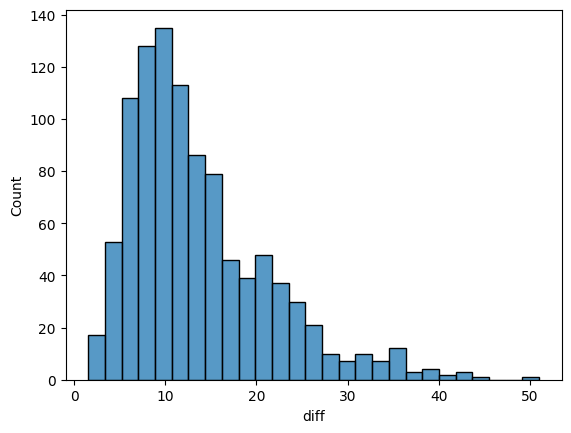

In [16]:
import seaborn as sns

sns.histplot(data=df, x='diff')

Seem like we are geeting an accuray of 10m, okay but can be improved using filtering and combinations. Let's see the plot of the coordinate.

In [17]:
# Let's get the real coordinates of the station
from navigator.utility import IGSNetwork

network = IGSNetwork()

real_coords = network.get_xyz(station=station)
real_coords = pd.Series(real_coords, index=['x', 'y', 'z'])
real_coords

x    2.106811e+06
y   -3.355171e+06
z   -4.981786e+06
dtype: float64

Let's scatter plot the coordinate hiligitng the real coordinate.

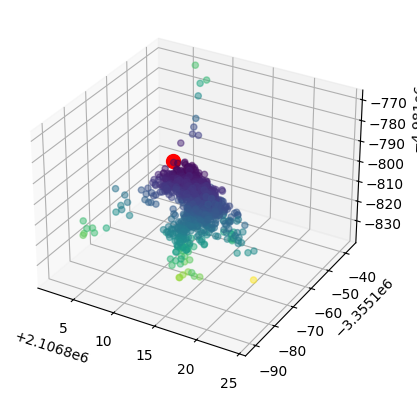

In [18]:
import matplotlib.pyplot as plt

# Scatter plot of predicted coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], c=df['diff'], cmap='viridis', alpha=0.5)

# Add real coordinates to the plot as a red dot
ax.scatter(real_coords['x'], real_coords['y'], real_coords['z'], c='red', s=100)

plt.show()